In [1]:
from PrepareOriginalData import PrepareData
from NeuralNetworkObjects import NeuralNetwork
import numpy as np

# Some constants
taskType = 'all'
data_amount = 0.1
epochs = 10

# Load training set
p = PrepareData(path_images='data_vqa_feat', # Path to image features 
                subset='train2014', # Desired subset: either train2014 or val2014
                taskType='OpenEnded', # 'OpenEnded', 'MultipleChoice', 'all'
                cut_data=data_amount, # Percentage of data to use, 1 = All values, above 1=#samples for debugging
                output_path='data', # Path where we want to output temporary data
                pad_length=32, # Number of words in a question (zero padded)
                question_threshold=0, answer_threshold=0, # Keep only most common words
                questions_sparse=True)
image_features, questions, answers, annotations = p.load_data()
print("Image features", image_features.shape)
print("Question features", questions.shape)
print("Answers", answers.shape)
print("Dictionary size", p.dic_size)

# Save dictionary
p.dumpDictionary()

Using TensorFlow backend.


loading VQA annotations and questions into memory...
0:00:04.169049
creating index...
index created!
Image features (24834, 1024)
Question features (24834, 32)
Answers (24834, 1)
Dictionary size 5408


In [3]:
# Extract object features
from ExtractObjects import ExtractObjects

# Consider three thresholds
eo = ExtractObjects(cut_data=data_amount, output_fileName='objects_train.txt', subset='train2014', threshold=25)
object_matrix1 = eo.onehotvector(annotations)
eo = ExtractObjects(cut_data=data_amount, output_fileName='objects_train.txt', subset='train2014', threshold=50)
object_matrix2 = eo.onehotvector(annotations)
eo = ExtractObjects(cut_data=data_amount, output_fileName='objects_train.txt', subset='train2014', threshold=75)
object_matrix3 = eo.onehotvector(annotations)

object_matrix = np.concatenate([object_matrix1, object_matrix2, object_matrix3], axis=1)
print(object_matrix.shape)
np.save('data/object_matrix_train.npy', object_matrix)

(24834, 240)


In [2]:
object_matrix = np.load('data/object_matrix_train.npy')

In [3]:
# Use this when using sparse representation
neuralnet = NeuralNetwork(image_features.shape[0],1024,questions.shape[1],p.dic_size,np.max(answers) + 1, objects=240, lr=0.001,
                          epochs = epochs, batchSize=64, loss='sparse_categorical_crossentropy', activation='softmax', monitor='val_loss')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 32)           0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 32, 32)       173056      word_input[0][0]                 
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 1024)         0                                            
__________________________________________________________________________________________________
objects_input (InputLayer)      (None, 240)          0                                            
__________________________________________________________________________________________________
flatten_em

In [4]:
# Train network
neuralnet.fit(image_features, object_matrix, questions, answers)

(24834, 1024) (24834, 240) (24834, 32) (24834, 1)
Train on 17383 samples, validate on 7451 samples
Epoch 1/10
 3392/17383 [====>.........................] - ETA: 5:26 - loss: 12.3020 - acc: 0.2264

KeyboardInterrupt: 

In [9]:
# Test prediction on training set
from EvaluateModel import ProduceResult

# Predict
# pred = neuralnet.predict(image_features, questions, 'weights/weights-05-3.1614.hdf5')
pred = neuralnet.predict_current_state(image_features, object_matrix, questions)
print(pred.shape)

# Evaluate
model_evaluator = ProduceResult(p._int_to_answer, p._answer_to_int, dataSubType='train2014')
model_evaluator.produce_results(pred, p._original_questions)
model_evaluator.evaluate(taskType='OpenEnded')

(24834, 280)
loading VQA annotations and questions into memory...
0:00:04.220523
creating index...
index created!
Loading and preparing results...     
DONE (t=0.04s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 55.06

Per Question Type Accuracy is the following:
what : 24.93
is there a : 92.28
is this : 80.41
is this a : 80.53
what color is the : 61.30
what is on the : 18.70
is the : 79.87
are these : 79.66
what is : 22.68
what is in the : 35.00
where is the : 10.00
what color are the : 58.56
where are the : 15.40
what animal is : 38.45
none of the above : 50.53
what kind of : 24.22
what is the : 23.83
are there any : 81.66
how : 7.83
what color is : 63.72
how many : 62.29
why is the : 7.12
who is : 13.68
is the person : 70.95
what color : 54.04
does this : 81.63
can you : 84.69
what is this : 33.82
does the : 81.70
is this person : 75.67
is : 85.96
which : 46.01
is the man : 84.22
what i

In [10]:
# Load validation set and evaluate prediction on it
image_features = questions = answers = annotations = []
pt= PrepareData(path_images='data_vqa_feat', # Path to image features 
                subset='val2014', # Desired subset: either train2014 or val2014
                taskType=taskType, # 'OpenEnded', 'MultipleChoice', 'all'
                cut_data=data_amount, # Percentage of data to use, 1 = All values, above 1 = 10 samples for debugging
                output_path='data')
pt.loadDictionary('data/dictionary.pkl') # Use same dictionary as in training
image_features, questions, answers, annotations = pt.load_data()
print("Image features", image_features.shape)
print("Question features", questions.shape)
print("Answers", answers.shape)
print("Dictionary size", pt.dic_size)

loading VQA annotations and questions into memory...
0:00:01.998432
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:03.367647
creating index...
index created!
Image features (24302, 1024)
Question features (24302, 32)
Answers (24302, 1)
Dictionary size 5408


In [11]:
# Extract object features
from ExtractObjects import ExtractObjects
# Consider three thresholds
eo = ExtractObjects(cut_data=data_amount, output_fileName='objects_val.txt', subset='val2014', threshold=25)
object_matrix1 = eo.onehotvector(annotations)
eo = ExtractObjects(cut_data=data_amount, output_fileName='objects_val.txt', subset='val2014', threshold=50)
object_matrix2 = eo.onehotvector(annotations)
eo = ExtractObjects(cut_data=data_amount, output_fileName='objects_val.txt', subset='val2014', threshold=75)
object_matrix3 = eo.onehotvector(annotations)

object_matrix = np.concatenate([object_matrix1, object_matrix2, object_matrix3], axis=1)

In [12]:
# Test prediction on validation set
# pred = neuralnet.predict(image_features, questions, 'weights/weights-05-4.9527.hdf5')
pred = neuralnet.predict_current_state(image_features, object_matrix, questions)
print(pred.shape)

(24302, 280)


In [14]:
from EvaluateModel import ProduceResult
model_evaluator = ProduceResult(pt._int_to_answer, pt._answer_to_int, dataSubType='val2014')
answers = model_evaluator.produce_results(pred, pt._original_questions)
model_evaluator.evaluate(taskType=taskType)

loading VQA annotations and questions into memory...
0:00:01.912943
creating index...
index created!
Loading and preparing results...     
DONE (t=0.02s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 37.59

Per Question Type Accuracy is the following:
what is the : 10.76
is the : 63.68
what : 10.65
is this an : 60.68
are there : 68.88
what is in the : 9.38
is it : 69.52
what is : 7.46
how many : 33.05
is this : 64.23
is there a : 84.66
is the person : 53.02
is this a : 69.79
what color is the : 31.40
how : 3.03
do : 67.73
how many people are in : 21.46
why : 4.16
are the : 63.95
none of the above : 36.59
are : 67.45
does this : 65.08
what is the person : 18.18
what are : 15.63
who is : 1.56
what brand : 4.00
has : 61.09
what kind of : 12.71
is the man : 64.12
are they : 65.35
what type of : 8.29
is : 59.95
is this person : 62.63
what is the man : 20.54
are these : 65.16
how many people are 

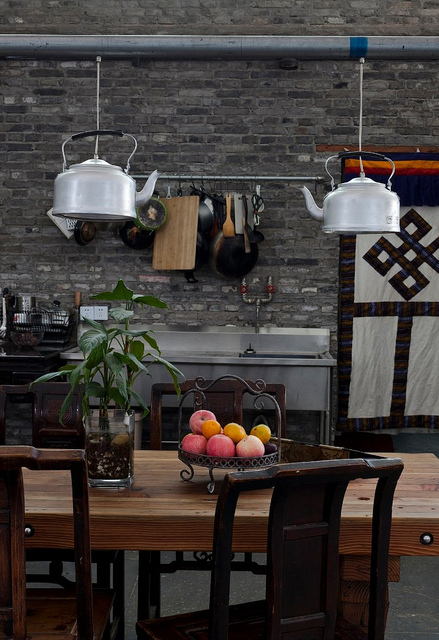

What is the table made of??
wood: 0.881206; tile: 0.00619131; white: 0.00438422; 
Ground truth: wood
[{'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'wood', 'answer_confidence': 'maybe', 'answer_id': 8}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 10}]


Is the food napping on the table??
yes: 0.849235; no: 0.150758; 2: 2.35798e-06; 
Ground truth: no
[{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'no', 'answer_confi

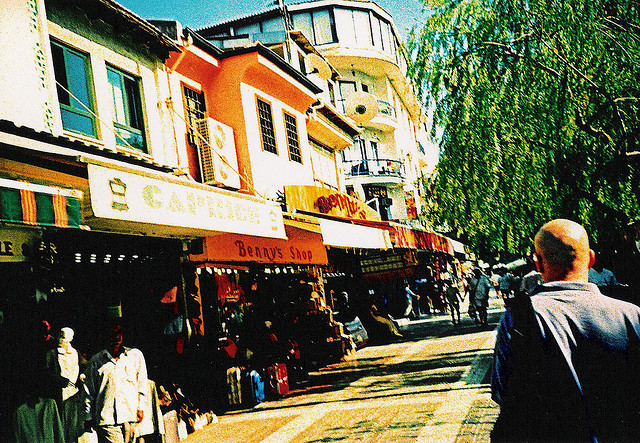

Is this an Spanish town??
yes: 0.652133; no: 0.347398; left: 4.08431e-05; 
Ground truth: no
[{'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 2}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 5}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 8}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 10}]


Are there shadows on the sidewalk??
yes: 0.997748; no: 0.00224704; left: 1.92206e-06; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confid

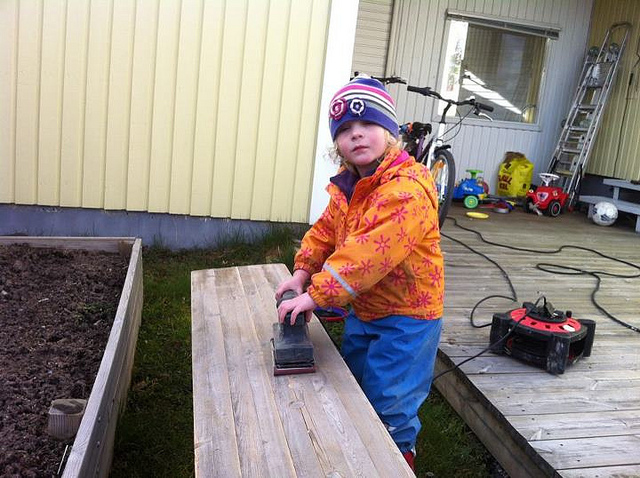

Is it cold outside??
yes: 0.90871; no: 0.0893918; right: 0.00183784; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}]


What is leaning against the house??
2: 0.00211706; pizza: 0.00138283; right: 0.000707459; 
Ground truth: ladder
[{'answer': 'ladder', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'ladder', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'ladder', 'answer_co

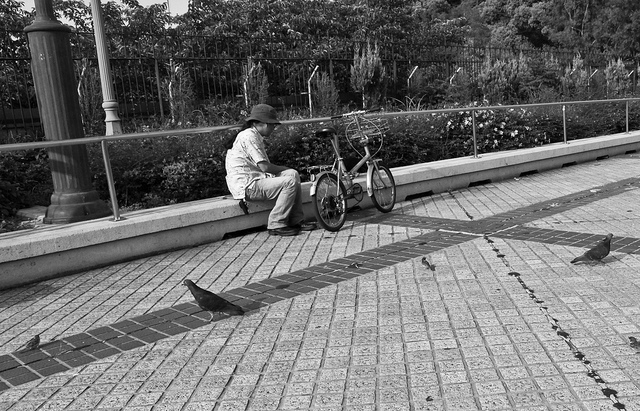

Is this in a park??
yes: 0.593727; no: 0.406251; outside: 3.67713e-06; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 9}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}]


Is there a bicycle in this picture??
yes: 0.841424; no: 0.158528; 2: 6.67776e-06; 
Ground truth: yes
[{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'yes', 'answer_confidence': 'yes', 'a

In [15]:
# Visualize prediction
from IPython.display import Image,display

def visualize_image_question_answer(index):
    if index % 3 == 0:
        subset_path = 'VQA/Images/mscoco/' + pt.subset + '/'
        image_path = subset_path + 'COCO_' + pt.subset + '_'+ str(annotations[index]["image_id"]).zfill(12) + '.jpg'
        display(Image(image_path,width=300))
        
    print(pt._original_questions[index]["question"] + '?')
    print(answers[index])
    print('Ground truth:', annotations[index]['multiple_choice_answer'])
    print(annotations[index]['answers'])
    print('\n')
    
for i in range(0,12):
    visualize_image_question_answer(i)